In [1]:
from astroquery.sdss import SDSS
from astroquery.exceptions import TimeoutError as AQTimeoutError
from urllib.error import URLError
from astropy.table import Table
import pandas as pd
import numpy as np
# astronomy things
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle 
import astropy.units as u
from astropy.wcs import WCS
from astropy.stats import sigma_clip
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval, LogStretch, LinearStretch, SinhStretch, AsinhStretch, make_lupton_rgb

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.optimize import curve_fit
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import time

from pathlib import Path

In [25]:
# verify none of teh cihps are equal
print("starting...")

data_dir = Path("./chips")
contents_glob = data_dir.glob("**/*.jpeg")
contents = [np.asarray(Image.open(content)) for content in contents_glob]
data_dir = Path("./chips2")
contents_glob = data_dir.glob("**/*.jpeg")
contents_names = [fi.name for fi in contents_glob]
print(f"Length of contents = {len(contents)}")


starting...
Length of contents = 79490
Looping...


KeyboardInterrupt: 

In [30]:
dupe_idxs = []
print("Looping...")
i = 0

del_per_sec = []
tstart = time.time()
while len(contents) > 0:
# for idx, data in enumerate(contents):
    print(f"{len(contents)}" , end='\r')
    # print(f"{idx}", end='\r')
    data = contents[0]
    contents_copy = contents.copy()
    del contents_copy[0]
    for other_idx, other_data in enumerate(contents_copy):
        try:
            if data.shape == other_data.shape:
                if (data == other_data).all():
                    dupe_idxs.append(idx)
                
        except Exception as e:
            print(e)
    del contents[0]
    del_per_sec.append(1)
    tend = time.time()
    if tend - tstart > 1:
        tstart = tend
        print(f"\t\tDeleted in 1 s: {len(del_per_sec)}",end ='\r')
        del_per_sec = []
print(f"Dupe IDXs = {dupe_idxs}")

print([contents_names[i] for i in dupe_idxs])

Looping...


In [181]:
def sigmoid(x):
    """
    uses sigmoid function to scale while perserving relative distance
    """
    return (1 / (1 + np.e**(-x)))


def gaussian_2d(xy, A, mu_x, sig_x, mu_y, sig_y, theta, offset):
    x, y = xy
    a = (   np.cos(theta) ** 2 )   / (2 * sig_x ** 2) + (np.sin(theta) ** 2) / (2 * sig_y ** 2)
    b = (  -np.sin(2*theta)    )   / (4 * sig_x ** 2) + (np.sin(2*theta)   ) / (4 * sig_y ** 2)
    c = (   np.sin(theta) ** 2 )   / (2 * sig_x ** 2) + (np.cos(theta) ** 2) / (2 * sig_y ** 2)
    g =  offset + A * np.exp( -1 * ( a * (x - mu_x) ** 2  + 2 * b * (x - mu_x)*(y - mu_y) + c * (y - mu_y) ** 2 ))
    return g.ravel()
    
    

In [182]:
df = pd.read_csv("data/star_classification.csv")
bands = ['u', 'g', 'r', 'i', 'z']



In [205]:
def fit_2d_gaussian(chip_data, object, band, ax=None, reshape=True):
    center_chip_x, center_chip_y = chip_data.shape[1] / 2, chip_data.shape[0] / 2
    
    ellipse = None
    try:
        # fit a 2-d gaussian to get a sigma for 99% of the object
        x_fit = np.arange(0, chip_data.shape[0])
        y_fit = np.arange(0, chip_data.shape[1])
        x_fit, y_fit = np.meshgrid(x_fit, y_fit)
        initial_guess = (1, center_chip_x, 1, center_chip_y, 1, 0, 0)
        popt, pcov = curve_fit(gaussian_2d, (x_fit, y_fit), chip_data.ravel(), p0=initial_guess)
        A, mu_x, sig_x, mu_y, sig_y, theta, offset = popt
        theta_deg = 180 / np.pi * theta
        
        
        # add a gaussian 
        n_sig = 3
        dy = abs(sig_y * (n_sig + 2))
        dx = abs(sig_x * (n_sig + 2))
        
        if reshape:
            dy = dy if dy >= 5 else 5
            dx = dx if dx >= 5 else 5
            chip_data = chip_data[int(center_chip_y - dy): int(center_chip_y + dy), 
                                int(center_chip_x - dx): int(center_chip_x + dx)]
            
            
            mu_x = mu_x - (center_chip_x - dx)
            mu_y = mu_y - (center_chip_y - dy)
         
        if ax:  
            ellipse = patches.Ellipse((mu_x, mu_y), sig_y * n_sig*2, sig_x * n_sig*2, theta_deg, fill=False, color='red', zorder=2) # n_sig * 2 because this takes diameter
            ax.add_patch(ellipse)

            
        print(f"{chip_data.shape = }")
        
        return ax, chip_data, ellipse
    except Exception as e:
        # we werent able to fit a gaussian. we should still make the chip become 20x20
        if reshape:
            chip_data = chip_data[int(center_chip_y - 10):int(center_chip_y + 10), int(center_chip_x-10):int(center_chip_x+10 )]
        print(f"EXCEPTION {e}. SKIPPING.")
        return ax, chip_data, ellipse
        

idx = 4	 GALAXY


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
C:\Users\hbar6\AppData\Local\Temp\ipykernel_13216\2880926533.py:32: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = patches.Ellipse((mu_x, mu_y), sig_y * n_sig*2, sig_x * n_sig*2, theta_deg, fill=False, color='red', zorder=2) # n_sig * 2 because this takes diameter


chip_data.shape = (81, 55)
chip_data.shape = (81, 55)
chip_data.shape = (81, 55)


KeyboardInterrupt: 

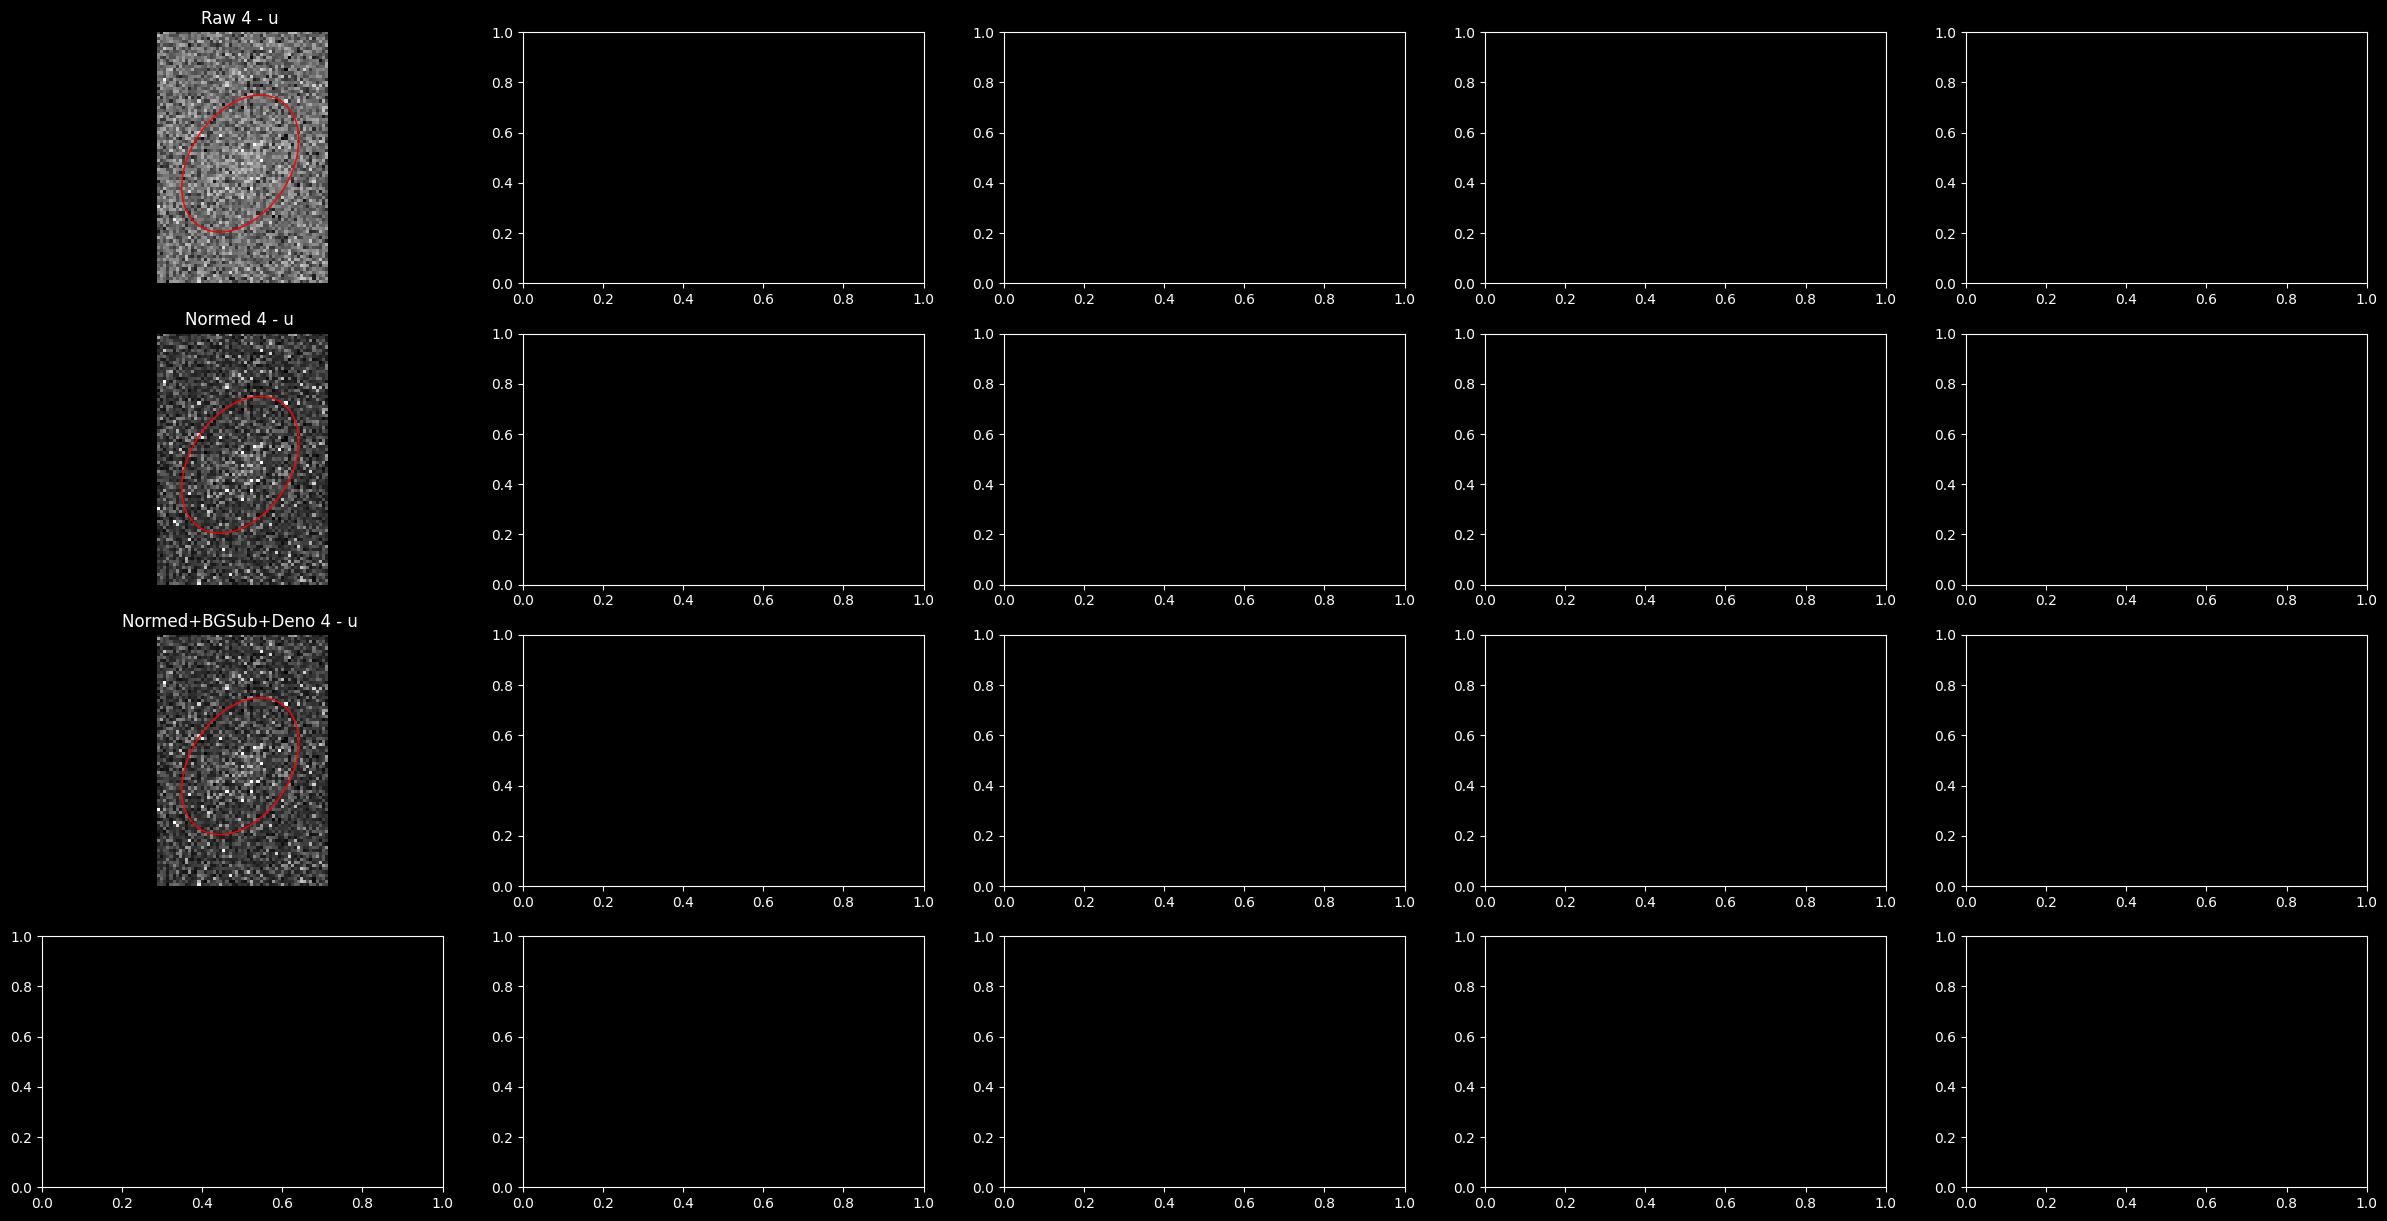

In [184]:
fig,ax = plt.subplots(4,5)
fig.set_size_inches(30,15)


idx = np.random.randint(0,100_000)

idx = 4
# idx = 68181	 	 
# idx = 85129	 	
# idx = 44570
# idx =16474
object = df.iloc[idx]
print(f"idx = {idx}\t {object['class']}")
run_id = object['run_ID']
rerun_id = object['rerun_ID']
cam_col = object['cam_col']
field_id = object['field_ID']
spec_obj_id = object['spec_obj_ID']

# get coordinates of object RA/DEC
ra = Angle(object['alpha'], unit=u.deg)
dec = Angle(object['delta'], unit=u.deg)
c = SkyCoord(ra, dec, frame='icrs')

xids_table = SDSS.query_region(c) # this can return multiple items
xids = xids_table.to_pandas()
xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))

# LOOP OVER ALL IMAGES HERE

img_data_buffer = [SDSS.get_images(matches=best_plate, band = band) for band in bands]
for idx, (img, band) in enumerate(zip(img_data_buffer,bands)):
    header = img[0][0].header
    wcs = WCS(header)
    obj_pix_x, obj_pix_y = wcs.world_to_pixel(c)

    chip_size = 50
    slice_y_0, slice_y_1 = int(obj_pix_y-chip_size), int(obj_pix_y+chip_size)
    slice_x_0, slice_x_1 = int(obj_pix_x-chip_size), int(obj_pix_x+chip_size)
    # slice_y_0, slice_y_1 = 10, -10
    # slice_x_0, slice_x_1 = 10, -10
    
    
    img_data = img[0][0].data.copy()

    # make initial large chip of the object we are interested in
    chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    center_chip_x, center_chip_y = chip_data.shape[1] / 2, chip_data.shape[0] / 2


    
    # plotting
    ax[0,idx], chip_data, ellipse = fit_2d_gaussian(chip_data, object, band, ax[0, idx])
    ax[0,idx].imshow(chip_data, cmap='gray', zorder = 1)
    ax[0,idx].axis('off')
    ax[0,idx].set_title(f"Raw {object.name} - {band} ")
    
    
    
    
    
    
    
    
    # no noise reduction, no background subtraction
    # make chips of the object we are interested in
    chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[1,idx], chip_data, ellipse = fit_2d_gaussian(chip_data, object, band, ax[1, idx])
    ax[1,idx].imshow(chip_data, cmap='gray', norm=norm, zorder=1)
    ax[1,idx].axis('off')
    ax[1,idx].set_title(f"Normed {object.name} - {band} ")
    
    
    
    
    # try with noise and background subtraction
    noise = np.std(img_data)
    background = np.median(img_data)
    cleaned_img_data = (img_data - background) / noise

    # chips
    chip_data = cleaned_img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[2,idx], chip_data, ellipse = fit_2d_gaussian(chip_data, object, band, ax[2, idx])
    ax[2,idx].imshow(chip_data, cmap='gray', norm=norm, zorder=1)
    ax[2,idx].axis('off')
    ax[2,idx].set_title(f"Normed+BGSub+Deno {object.name} - {band} ")
    
    
    
    
    
    
    # sigma clipped stats
    clipped_data = sigma_clip(img_data)
    median = np.median(clipped_data) # bias
    std = np.std(clipped_data) # noise
    sigma_cleaned_img_data = (img_data - median) / std
    
    # chips
    chip_data = sigma_cleaned_img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[3, idx], chip_data, ellipse = fit_2d_gaussian(chip_data, object, band, ax[3, idx])
    ax[3,idx].imshow(chip_data, cmap='gray', norm=norm, zorder=1)
    ax[3,idx].axis('off')
    ax[3,idx].set_title(f"Normed+BGSub+Deno(sigma) {object.name} - {band} ")
    
    
    
    





In [ ]:
fig.savefig("./media/centroiding.png", dpi=1000, bbox_inches='tight')

In [217]:
from requests.exceptions import ConnectionError

def get_imgs(df, last_idx):
    try:
        for obj_idx, row in df.iloc[last_idx:].iterrows():
            print(f"{obj_idx / len(df)*100:.1f}", end='\r')
            object = row
            run_id = object['run_ID']
            rerun_id = object['rerun_ID']
            cam_col = object['cam_col']
            field_id = object['field_ID']
            spec_obj_id = object['spec_obj_ID']

            # get coordinates of object RA/DEC
            ra = Angle(object['alpha'], unit=u.deg)
            dec = Angle(object['delta'], unit=u.deg)
            c = SkyCoord(ra, dec, frame='icrs')

            xids_table = SDSS.query_region(c) # this can return multiple items
            xids = xids_table.to_pandas()
            xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
            xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
            best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

            best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))

            # LOOP OVER ALL IMAGES HERE
            img_data_buffer = [SDSS.get_images(matches=best_plate, band = band) for band in bands]
            for idx, (img, band) in enumerate(zip(img_data_buffer,bands)):
                
                out_dir = Path("./chips")
                out_dir = out_dir / band
                header = img[0][0].header
                wcs = WCS(header)
                obj_pix_x, obj_pix_y = wcs.world_to_pixel(c)

                chip_size = 50
                slice_y_0, slice_y_1 = int(obj_pix_y-chip_size), int(obj_pix_y+chip_size)
                slice_x_0, slice_x_1 = int(obj_pix_x-chip_size), int(obj_pix_x+chip_size)
                # slice_y_0, slice_y_1 = 10, -10
                # slice_x_0, slice_x_1 = 10, -10
                
                
                img_data = img[0][0].data.copy()

                # make initial large chip of the object we are interested in
                chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
                center_chip_x, center_chip_y = chip_data.shape[1] / 2, chip_data.shape[0] / 2


                
                # plotting
                _, chip_data, ellipse = fit_2d_gaussian(chip_data, object, band, None, reshape=True)

                interval = ZScaleInterval(max_iterations=10)
                vmin, vmax = interval.get_limits(chip_data)
                norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch(), clip=True)
                chip_data = norm(chip_data)    
                
                im = Image.fromarray((chip_data*255).astype('uint8'))
                im = im.convert("L")
                # im.show()
                im.save(f"./chips/{obj_idx}-{band}.jpeg")
                
    except ConnectionAbortedError:
        time.sleep(30)
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        try:
            data_dir = Path("./chips")
            contents = data_dir.glob("**/*.jpeg")
            idxs = list(set([int(content.name.split('-')[0]) for content in contents]))
            last_idx = idxs[-2]
            get_imgs(df, last_idx)
        except IndexError:
            last_idx = 0

    except ConnectionError:
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        time.sleep(30)
        try:
            data_dir = Path("./chips")
            contents = data_dir.glob("**/*.jpeg")
            idxs = list(set([int(content.name.split('-')[0]) for content in contents]))
            last_idx = idxs[-2]
            get_imgs(df, last_idx)
        except IndexError:
            last_idx = 0
    
    except TimeoutError:
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        time.sleep(30)
        try:
            data_dir = Path("./chips")
            contents = data_dir.glob("**/*.jpeg")
            idxs = list(set([int(content.name.split('-')[0]) for content in contents]))
            last_idx = idxs[-2]
            get_imgs(df, last_idx)
        except IndexError:
            last_idx = 0
            
    except AQTimeoutError:
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        print("Sleeping...")
        time.sleep(30)
        try:
            data_dir = Path("./chips")
            contents = data_dir.glob("**/*.jpeg")
            idxs = list(set([int(content.name.split('-')[0]) for content in contents]))
            last_idx = idxs[-2]
            get_imgs(df, last_idx)
        except IndexError:
            last_idx = 0


In [218]:
try:
    data_dir = Path("./chips")
    contents = data_dir.glob("**/*.jpeg")
    idxs = list(set([int(content.name.split('-')[0]) for content in contents]))
    last_idx = idxs[-2]
except IndexError:
    last_idx = 0

get_imgs(df, last_idx)